<a href="https://colab.research.google.com/github/AmeyHengle/Arabic-Sentiment-Identification/blob/main/main/Fasttext_300dim_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from time import process_time
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from custom_functions import *
from custom_models import *

# Prepare Data

**1. Load train and val**

In [ ]:
# D_train = read_data()
# D_test = read_data()
data = read_data("/content/preprocessed_2.csv")
D_train, D_test =  train_test_split(data ,test_size=0.2, random_state=42)

x_train = D_train['tweet']
y_train = D_train['sarcasm'].values.tolist()
x_val = D_test['tweet']
y_val = D_test['sarcasm'].values.tolist()

print('\ntraining data: {}\t validation data: {}'.format(len(x_train),len(x_val)),
      '\ntraining classes: {}\t validation classes: {} \n'.format(np.unique(y_val),np.unique(y_val)))



training data: 10038	 validation data: 2510 
training classes: [False  True]	 validation classes: [False  True] 



**2. Clean and Preprocess**

In [ ]:
# Clean Text
x_train = x_train.apply(lambda x : clean_text(x)).values.tolist()
x_val = x_val.apply(lambda x : clean_text(x)).values.tolist()
# Preprocess Text


# Tokenize Text
tokenizer, x_train_tokenized, x_val_tokenized = tokenize_text(data['tweet'].values.tolist(),
                                                               x_train, x_val)

print('x_train_tokenized:',len(x_train_tokenized),'\nx_val_tokenized:',len(x_val_tokenized),
      "\nTotal Vocab: ",len(tokenizer.word_counts))

In [ ]:
# Pad Text
maximum_text_length = 100
padding_type = "post"
truncating_type = "post"

x_train_padded = pad_text_sequence(x_train_tokenized, maximum_text_length, padding_type, truncating_type)
x_val_padded = pad_text_sequence(x_val_tokenized, maximum_text_length, padding_type, truncating_type)

print('x_train_padded:',x_train_padded.shape,'\nx_val_padded',x_val_padded.shape)

x_train_padded: (10038, 100) 
x_val_padded (2510, 100)


**3. Encode target variables (labels) to integers**



In [ ]:
y_train = get_label_encoding(y_train)
y_val = get_label_encoding(y_val)

print(y_train.shape, y_val.shape)

Mapping:
{False: 0, True: 1}
Mapping:
{False: 0, True: 1}
(10038, 1) (2510, 1)


**4. Generate Embedding Matrix**

In [ ]:
# Load word embeddings from file
vocab = tokenizer.word_index
embedding_dimension = 300
embeddings_file = '/content/drive/MyDrive/Arabic Sentiment Identification shared task 2021/Word Embeddings (Trained on preprocessed_1.csv)/fasttext_model-skipgram_dim-300.vec'

embedding_matrix = get_word_embeddings(embeddings_file,vocab,embedding_dimension)

# Get sentence embeddings

# Validate embedding_matrix shape
print("Total Vocab:",len(vocab), "\nEmbeddings:",embedding_matrix.shape[0] -1 )

Total word embeddings read: 46872

Total Vocab: 47133 
Embeddings: 47133


**5. Train Model**

# Feed Forward Neural Network (FFNN)

In [ ]:
# Define callback
custom_callback = myCallbacks(metrics="acc", threshold = 0.95)

# Define model hyperparameters
input_length = maximum_text_length
embedding_vocab = embedding_matrix.shape[0]
embedding_dimension = embedding_matrix.shape[1]
output_dimension = len(np.unique(y_train))

print('Shape of each Input Sentence: ',input_length,"x",embedding_dimension)
print('Shape of Input layer: ',len(x_train),"x",embedding_dimension)
print("Output classes: ",output_dimension)

# Load model
FFNN_model = FFNN(input_length = input_length, input_dimension = embedding_vocab, 
                  embedding_dimension = embedding_dimension, output_dimension = output_dimension,
                  embedding_matrix = embedding_matrix, num_layers = 3, trainable = True)

# View model summary
print("\n\nModel Summary:")
FFNN_model.summary()

# Train model
print("\n\nTraining Model:")
model_history = FFNN_model.fit(x = np.asarray(x_train_padded), y = np.asarray(y_train),
                               validation_data = (np.asarray(x_val_padded),np.asarray(y_val)),
                               epochs = 10, callbacks = [custom_callback])

Shape of each Input Sentence:  100 x 300
Shape of Input layer:  10038 x 300
Output classes:  2


Model Summary:
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 300)          14140200  
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 300)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               38528     
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 66        
Total pa

In [ ]:
#print classification report
y_pred = np.argmax(FFNN_model.predict(x_val_padded),axis=-1)
print("\nClassification Report:\n\n",classification_report(y_true=y_val, y_pred = y_pred, labels = np.unique(y_val)))


Classification Report:

               precision    recall  f1-score   support

           0       0.92      0.77      0.84      2091
           1       0.37      0.67      0.47       419

    accuracy                           0.75      2510
   macro avg       0.64      0.72      0.66      2510
weighted avg       0.83      0.75      0.78      2510



# CNN

In [ ]:
# Define callback
custom_callback = myCallbacks(metrics="acc", threshold = 0.95)

# Define model hyperparameters
input_length = maximum_text_length
embedding_vocab = embedding_matrix.shape[0]
embedding_dimension = embedding_matrix.shape[1]
output_dimension = len(np.unique(y_train))

print('Shape of each Input Sentence: ',input_length,"x",embedding_dimension)
print('Shape of Input layer: ',len(x_train),"x",embedding_dimension)
print("Output classes: ",output_dimension)

# Load model
CNN_model = CNN(input_length = input_length, input_dimension = embedding_vocab, 
                  embedding_dimension = embedding_dimension, output_dimension = output_dimension,
                  embedding_matrix = embedding_matrix, num_layers = 1, trainable = False,
                   kernel_size = 5, dropout_rate = 0.25)

# View model summary
print("\n\nModel Summary:")
CNN_model.summary()

# Train model
print("\n\nTraining Model:")
model_history = CNN_model.fit(x = np.asarray(x_train_padded), y = np.asarray(y_train),
                               validation_data = (np.asarray(x_val_padded),np.asarray(y_val)),
                               epochs = 10, callbacks = [custom_callback])

Shape of each Input Sentence:  100 x 300
Shape of Input layer:  10038 x 300
Output classes:  2


Model Summary:
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 300)          14140200  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 96, 32)            48032     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 66        
Total params: 14,188,298
Trainable params: 48,098
Non-trainable params: 14,140,200
_________________________________________________________

In [ ]:
#print classification report
y_pred = np.argmax(CNN_model.predict(x_val_padded),axis=-1)
print("\nClassification Report:\n\n",classification_report(y_true=y_val, y_pred = y_pred, labels = np.unique(y_val)))


Classification Report:

               precision    recall  f1-score   support

           0       0.89      0.92      0.90      2091
           1       0.50      0.41      0.45       419

    accuracy                           0.83      2510
   macro avg       0.69      0.66      0.68      2510
weighted avg       0.82      0.83      0.83      2510



# BI-LSTM 1

In [ ]:
# Define callback
custom_callback = myCallbacks(metrics="acc", threshold = 0.95)

# Define model hyperparameters
input_length = maximum_text_length
embedding_vocab = embedding_matrix.shape[0]
embedding_dimension = embedding_matrix.shape[1]
output_dimension = len(np.unique(y_train))

print('Shape of each Input Sentence: ',input_length,"x",embedding_dimension)
print('Shape of Input layer: ',len(x_train),"x",embedding_dimension)
print("Output classes: ",output_dimension)

# Load model
BILSTM_model = BILSTM(input_length = input_length, input_dimension = embedding_vocab, 
                   embedding_dimension = embedding_dimension, output_dimension = output_dimension,
                   embedding_matrix = embedding_matrix, layer1 = 64, layer2 = 64, trainable = False,
                   dropout_rate = 0.25)

# View model summary
print("\n\nModel Summary:")
BILSTM_model.summary()

# Train model
print("\n\nTraining Model:")
model_history = BILSTM_model.fit(x = np.asarray(x_train_padded), y = np.asarray(y_train),
                               validation_data = (np.asarray(x_val_padded),np.asarray(y_val)),
                               epochs = 10, batch_size = 32, callbacks = [custom_callback])

Shape of each Input Sentence:  100 x 300
Shape of Input layer:  10038 x 300
Output classes:  2


Model Summary:
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 300)          14140200  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 128)          186880    
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 130       
Total params: 14,335,466
Trainable params: 195,266
Non-trainable params: 14,140,200
_______________________________________________________

In [ ]:
# print classification report
y_pred = np.argmax(BILSTM_model.predict(x_val_padded),axis=-1)
print("\nClassification Report:\n\n",classification_report(y_true=y_val, y_pred = y_pred, labels = np.unique(y_val)))


Classification Report:

               precision    recall  f1-score   support

           0       0.90      0.87      0.89      2091
           1       0.45      0.52      0.48       419

    accuracy                           0.81      2510
   macro avg       0.67      0.70      0.68      2510
weighted avg       0.83      0.81      0.82      2510



# BI-LSTM 2

In [ ]:
# Define callback
custom_callback = myCallbacks(metrics="acc", threshold = 0.95)

# Define model hyperparameters
input_length = maximum_text_length
embedding_vocab = embedding_matrix.shape[0]
embedding_dimension = embedding_matrix.shape[1]
output_dimension = len(np.unique(y_train))

print('Shape of each Input Sentence: ',input_length,"x",embedding_dimension)
print('Shape of Input layer: ',len(x_train),"x",embedding_dimension)
print("Output classes: ",output_dimension)

# Load model
BILSTM_model2 = BILSTM_2(input_length = input_length, input_dimension = embedding_vocab, 
                   embedding_dimension = embedding_dimension, output_dimension = output_dimension,
                   embedding_matrix = embedding_matrix)

# View model summary
print("\n\nModel Summary:")
BILSTM_model2.summary()

# Train model
print("\n\nTraining Model:")
model_history = BILSTM_model2.fit(x = np.asarray(x_train_padded), y = np.asarray(y_train),
                               validation_data = (np.asarray(x_val_padded),np.asarray(y_val)),
                               epochs = 10, batch_size = 32, callbacks = [custom_callback])

Shape of each Input Sentence:  100 x 300
Shape of Input layer:  10038 x 300
Output classes:  2


Model Summary:
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 300)          14140200  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100, 200)          320800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 100, 100)          20100     
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 100)               1000100   
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 202       
Total p

**6. Evaluate Model**

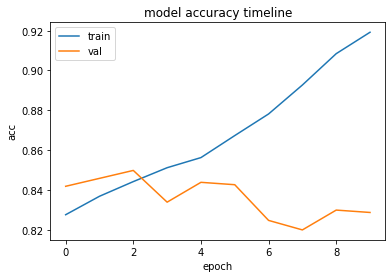

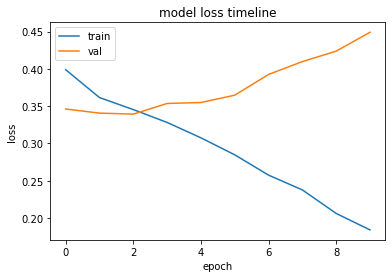


Classification Report:

               precision    recall  f1-score   support

           0       0.90      0.90      0.90      2091
           1       0.49      0.48      0.48       419

    accuracy                           0.83      2510
   macro avg       0.69      0.69      0.69      2510
weighted avg       0.83      0.83      0.83      2510



In [ ]:
# plot results
plot_results(model_history)

# print classification report
y_pred = np.argmax(BILSTM_model2.predict(x_val_padded),axis=-1)
print("\nClassification Report:\n\n",classification_report(y_true=y_val, y_pred = y_pred, labels = np.unique(y_val)))

In [ ]:
# save model
save_model(BILSTM_model2, "ASI_Sarcasm_BiLSTM2")

Saved as  ASI_Sarcasm_BiLSTM2


In [ ]:
while True:
  pass

KeyboardInterrupt: ignored

# CNN-LSTM